# Colab

In [ ]:
!nvidia-smi -L  

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -r sample_data

In [ ]:
!pip install timm

     |████████████████████████████████| 431 kB 8.4 MB/s 


In [ ]:
# !pip install albumentations==0.4.6

# Libraries

In [ ]:
import torch
import timm
import pandas as pd
import os
import cv2
import numpy as np

print("torch_version: " + torch.__version__)
print("timm_version: " + timm.__version__)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__, DEVICE

torch_version: 1.10.0+cu111
timm_version: 0.5.4


('1.10.0+cu111', 'cpu')

# csv

In [ ]:
PATH = "/content/drive/MyDrive/ISIC/2016"
os.listdir(PATH)

['ISBI2016_ISIC_Part3_Training_Data.zip',
 'ISBI2016_ISIC_Part3_Training_GroundTruth.csv',
 'ISBI2016_ISIC_Part3_Test_Data.zip',
 'ISBI2016_ISIC_Part3_Test_GroundTruth.csv',
 'ISBI2016_ISIC_Part3_Training_Data',
 'ISBI2016_ISIC_Part3_Test_Data']

In [ ]:
train_path = f'{PATH}/ISBI2016_ISIC_Part3_Training_Data/'
test_path = f'{PATH}/ISBI2016_ISIC_Part3_Test_Data/'

train_csv = f'{PATH}/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
test_csv = f'{PATH}/ISBI2016_ISIC_Part3_Test_GroundTruth.csv'

header_list = ['image_name','benign_malignant']
train = pd.read_csv(train_csv, names=header_list, index_col=False)

header_list = ['image_name','target']
test = pd.read_csv(test_csv, names=header_list, index_col=False)

In [ ]:
def to_int(label):
  if label == "benign":
    return 0.0
  elif label == "malignant":
    return 1.0

def to_path_train(image_name):
  return train_path +image_name+'.jpg'

def to_path_test(image_name):
  return test_path +image_name+'.jpg'
train['target'] = train.benign_malignant.apply(to_int)
train['path'] = train.image_name.apply(to_path_train)

test['path'] = test.image_name.apply(to_path_test)

# Hold out | Folds

In [ ]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(train, random_state=42, test_size=0.33, shuffle=True, stratify=train['target'])

train_split.reset_index(drop=True, inplace=True)
val_split.reset_index(drop=True, inplace=True)
train_split.shape, val_split.shape

((603, 4), (297, 4))

In [ ]:
import numpy as np
from sklearn import model_selection
FOLDS = 3
kf = model_selection.StratifiedKFold(n_splits=FOLDS, random_state=42, shuffle=True)
for fold_, (train_idx, test_idx) in enumerate(kf.split(X=train,y=train['target'])):
  train.loc[test_idx,'kfold'] = fold_

  train_fold = train.iloc[train_idx]
  val_fold = train.iloc[test_idx]
  train_fold.reset_index(drop=True, inplace=True)
  val_fold.reset_index(drop=True, inplace=True)
  train_fold.to_csv(f'./train_fold{FOLDS}.csv')
  val_fold.to_csv(f'./val_fold{FOLDS}.csv')
  print("Fold:",fold_+1)
  print(train_idx.shape, test_idx.shape)

# Dataset class

In [ ]:
params = {
    # "model": "resnet18",
    "model": "vit_large_patch16_224",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "im_size": 224,
    "lr": 0.001,
    "batch_size": 8,
    "num_workers": 4,
    "epochs": 25,
    "lr_scheduler": True,
    "early_stopping": True
}

In [ ]:
from torch.utils.data import Dataset
from skimage import io
from skimage.transform import resize

import cv2
class MelanomaDataset(Dataset):
  def __init__(self, images, labels=None, transform=None, train=True):
    self.images = images
    self.labels = labels
    self.transform = transform
    self.train = train

  def __getitem__(self, index):
    image = cv2.imread(self.images[index])
    image = cv2.resize(image, (params['im_size'],params['im_size']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target = torch.tensor([self.labels[index]])
    if self.transform is not None:
      # image = self.transform(image=image)["image"].astype(np.float32)/255.
      image = self.transform(image=image)["image"].astype(np.float32)
      # image = self.transform(image=image)["image"]
      image = image.transpose(2, 0, 1)/255.
    else:
      image = image/ 255.
      image = image.transpose(2, 0, 1)
    if self.train:
      return torch.tensor(image).float(), target.float()
    return torch.tensor(image).float()

  def __len__(self) -> int:
    return len(self.images)

In [ ]:
print("torch_version: " + cv2.__version__)

torch_version: 4.1.2


# Data Loader

In [ ]:
from torch.utils.data import DataLoader
dataset = {
    'train': MelanomaDataset(train_split['path'], train_split['target']),
    'val': MelanomaDataset(val_split['path'], val_split['target'])
}

In [ ]:
train_loader = DataLoader(dataset['train'], batch_size=params['batch_size'], shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset['val'], batch_size=params['batch_size'], pin_memory=True)

In [ ]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

# Show batch

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show_batch(data_loader):
  for images, labels in data_loader:
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

In [ ]:
show_batch(train_loader)

# Generate mean and std from dataset
mean: (0.7198314, 0.61556673, 0.5636417) \\
std: (0.16768907, 0.17222084, 0.19237213)

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
      # Mean over batch, height and width, but not over the channels
      channels_sum += torch.mean(data, dim=[0,2,3])
      channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
      num_batches += 1
    mean = channels_sum / num_batches
    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return tuple(mean.numpy()), tuple(std.numpy())

In [ ]:
mean, std = get_mean_and_std(DataLoader(dataset['train']))
print(mean)
print(std)

## compute_img_mean_std function (not used)

In [ ]:
#use this training model from scratch or not using pretrained model
from tqdm import tqdm
def compute_img_mean_std(image_paths):
    '''
    normalising data from 0-255 to 0-1
    mean and std of three channnel
    '''
    img_h, img_w = 224,224
    imgs = []
    means, stds = [],[]
    #resizing 
    for i in tqdm(image_paths):
        img = cv2.imread(i)
        img.resize(img_w,img_h)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        
    # (224,224,3),nof_img -> 224,224,3,nof_img
    imgs = np.stack(imgs, axis=3)
    #normalising 
    imgs=imgs.astype(np.float32)/255.
    
    print(imgs.shape)
    #mean and std of each channel
    for i in range(3):
        pixels = imgs[:,:,i,:].ravel() #resizing to one row
        mean = pixels.mean()
        std = pixels.std()
        
        means.append(mean)
        stds.append(std)
        
    means.reverse() #bgr to rgb
    stds.reverse()
    
    print(f'mean {means}')
    print(f'std {stds}')
    return means, stds

In [ ]:
compute_img_mean_std(train['path'])

# Augmentation

In [ ]:
mean= (0.72196096, 0.6170128, 0.56728417)
std= (0.16372901, 0.17203921, 0.19337493)


# mean= (0.7198314, 0.61556673, 0.5636417)
# std= (0.16768907, 0.17222084, 0.19237213)

In [ ]:
import albumentations as A

def transform_aug(im_size):
  transforms_train = A.Compose(
      [
       A.Transpose(p=0.5),
       A.VerticalFlip(p=0.5),
       A.HorizontalFlip(p=0.5),
       A.RandomBrightness(limit=0.2, p=0.75),
       A.RandomContrast(limit=0.2, p=0.75),
       A.OneOf([
                A.MotionBlur(blur_limit=5),
                A.MedianBlur(blur_limit=5),
                A.Blur(blur_limit=5),
                A.GaussNoise(var_limit=(5.0, 30.0)),
                ], p=0.7),
       A.OneOf([
                A.OpticalDistortion(distort_limit=1.0),
                A.GridDistortion(num_steps=5, distort_limit=1.),
                A.ElasticTransform(alpha=3),
                ], p=0.7),
       A.CLAHE(clip_limit=4.0, p=0.7),
       A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
       A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
       A.Resize(params['im_size'], params['im_size']),
       A.Cutout(max_h_size=int(im_size * 0.375), max_w_size=int(im_size * 0.375), num_holes=1, p=0.7),
      #  A.Normalize(mean,std)
      #  A.Normalize()
       ])
  
  transforms_val = A.Compose(
      [
       A.SmallestMaxSize(max_size=160),
       A.CenterCrop(height=128, width=128),
       A.Resize(params['im_size'], params['im_size']),
      #  A.Normalize(mean, std)
      #  A.Normalize()
       ])
  return transforms_train, transforms_val

In [ ]:
import albumentations as A
def transform_aug(im_size):
  transforms_train = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Resize(224,224),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Normalize(mean, std)
        # A.Normalize()
    ]
)
  
  transforms_val = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Resize(224,224),
        # A.Normalize()
        A.Normalize(mean, std)
    ])
  return transforms_train, transforms_val

In [ ]:
import albumentations as A
def transform_aug(im_size):
  transforms_train = A.Compose(
    [
        A.RandomSizedCrop(min_max_height=(200, 200), height=256, width=256, p=0.5),
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Resize(height=224, width=224, p=1),
        A.Cutout(num_holes=4, max_h_size=16, max_w_size=16, p=0.5),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # A.Normalize(mean, std)
        # A.Normalize()
    ]
)
  
  transforms_val = A.Compose(
    [
        A.Resize(height=224, width=224, p=1.0),
        # A.SmallestMaxSize(max_size=160),
        # A.CenterCrop(height=128, width=128),
        # A.Resize(224,224),
        # A.Normalize()
        # A.Normalize(mean, std)
    ])
  return transforms_train, transforms_val

In [ ]:
from torch.utils.data import DataLoader
transforms_train, transforms_val = transform_aug(params['im_size'])

dataset = {
    'train': MelanomaDataset(train_split['path'], train_split['target'],transform=transforms_train),
    'val': MelanomaDataset(val_split['path'], val_split['target'],transform=transforms_val)
}

train_loader = DataLoader(dataset['train'], batch_size=params['batch_size'], shuffle=True)
val_loader = DataLoader(dataset['val'], batch_size=params['batch_size'])

images, labels = next(iter(train_loader))
images.shape, labels.shape

In [ ]:
torch.max(images[4])

In [ ]:
images[7].shape

In [ ]:
images[1].dtype

In [ ]:
# import matplotlib.pyplot as plt
# plt.imshow(images[4])
# plt.show()



In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[3].permute(1,2,0))
plt.show()

In [ ]:
images, labels = next(iter(val_loader))
images.shape, labels.shape

In [ ]:
from torch.utils.data import DataLoader
transforms_train, transforms_val = transform_aug(224)

dataset = {
    'train': MelanomaDataset(train_fold['path'], train_fold['target'],transform=transforms_train),
    'val': MelanomaDataset(val_fold['path'], val_fold['target'],transform=transforms_val)
}

train_loader = DataLoader(dataset['train'], batch_size=params['batch_size'], shuffle=True)
val_loader = DataLoader(dataset['val'], batch_size=params['batch_size'])

images, labels = next(iter(train_loader))
images.shape, labels.shape

## Visualize augmentation

In [ ]:
import random
import copy
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image.permute(1,2,0))
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
random.seed(0)
visualize_augmentations(dataset['train'],3,15)

# Model

In [ ]:
model = timm.create_model(params['model'], pretrained=True, num_classes=10)
# model.get_classifier()
model.default_cfg

{'architecture': 'vit_large_patch16_224',
 'classifier': 'head',
 'crop_pct': 0.9,
 'first_conv': 'patch_embed.proj',
 'fixed_input_size': True,
 'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.5, 0.5, 0.5),
 'num_classes': 1000,
 'pool_size': None,
 'std': (0.5, 0.5, 0.5),
 'url': 'https://storage.googleapis.com/vit_models/augreg/L_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.1-sd_0.1--imagenet2012-steps_20k-lr_0.01-res_224.npz'}

In [ ]:
import timm
import torch.nn as nn
class MelanomaClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=True, num_classes = n_class)
        # n_features = self.model.classifier.in_features
        # n_features = self.model.fc.in_features
        # self.model.classifier = nn.Linear(n_features, n_class)
    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = MelanomaClassifier(params['model'],n_class=1,pretrained=True)

## parameters

In [ ]:
from timm.optim import AdamP
from timm.loss import BinaryCrossEntropy

optimizer = AdamP(model.parameters(), lr=params['lr'])
# criterion = BinaryCrossEntropy()

criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()

## Learning rate scheduler | Early stopping

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
class LRSchedulerPlateau():
  def __init__(self, optimizer, patience_t=1, mode="min", factor=0.8, min_lr=1e-7):
    self.optimizer = optimizer
    self.patience_t = patience_t
    self.mode = mode
    self.factor = factor
    self.min_lr = min_lr
    self.lr_scheduler = ReduceLROnPlateau( self.optimizer, mode='min', patience=self.patience_t, factor=self.factor, min_lr=self.min_lr, verbose=True)
  def __call__(self, val_loss):
    self.lr_scheduler.step(val_loss)

### Early stopping

In [ ]:
class EarlyStopping():
  def __init__(self, patience=3, min_delta=0.0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = None
    self.early_stop = False
  def __call__(self, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
    if self.counter >= self.patience:
      print('INFO: Early stopping')
      self.early_stop = True

# Metrics

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def auc_score(outputs, targets):
  # outputs = torch.sigmoid(outputs)
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  auc = roc_auc_score(targets, outputs)
  return auc

def f1_score_(outputs, targets):
  # outputs = outputs >= 0.5
  outputs = outputs >= 0.0
  targets = targets == 1.0
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  f1 = f1_score(targets, outputs, average='weighted')
  return f1

def recall_score_(outputs, targets):
  # outputs = outputs >= 0.5
  outputs = outputs >= 0.0
  targets = targets == 1.0
  outputs = outputs.cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  recall_ = recall_score(targets, outputs)
  return recall_
  

def accuracy_score(outputs, targets):
  # output = torch.sigmoid(outputs) >= 0.5
  # outputs = outputs >= 0.5
  outputs = outputs >= 0.0
  targets = targets == 1.0
  return torch.true_divide((targets == outputs).sum(dim=0), outputs.size(0)).item()

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Train

In [ ]:
from collections import defaultdict
class MetricMonitor:
  def __init__(self, float_precision=3):
    self.float_precision = float_precision
    self.reset()
    
  def reset(self):
    self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

  def update(self, metric_name, val):
    metric = self.metrics[metric_name]

    metric["val"] += val
    metric["count"] += 1
    metric["avg"] = metric["val"] / metric["count"]
  def __str__(self):
    return " | ".join(
        ["{metric_name}: {avg:.{float_precision}f}".format(metric_name=metric_name,
                                                           avg=metric["avg"],
                                                           float_precision=self.float_precision)
        for (metric_name, metric) in self.metrics.items()])

In [ ]:
from statistics import mean
def train(train_loader, model, criterion, optimizer, epoch, params):
  metric_monitor = MetricMonitor()
  model.train()
  stream = tqdm(train_loader)
  train_running_loss = []
  train_running_acc = []
  train_running_auc = []
  train_running_f1 = []
  for _, batch in enumerate(stream, start=1):
    images, targets = batch
    images = images.to(params["device"], non_blocking=True)
    targets = targets.to(params["device"], non_blocking=True).float().view(-1, 1)
    outputs = model(images)
    loss = criterion(outputs, targets)
    accuracy = accuracy_score(outputs, targets)
    # auc = auc_score(outputs, targets)
    f1 = f1_score_(outputs, targets)    
    
    train_running_loss.append(loss.item())
    train_running_acc.append(accuracy)
    # train_running_auc.append(auc)
    train_running_f1.append(f1)

    metric_monitor.update("Loss", loss.item())
    metric_monitor.update("Accuracy", accuracy)
    metric_monitor.update("F1", f1)
    # metric_monitor.update("AUC", auc)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("\n")
    stream.set_description("Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
  return mean(train_running_loss), mean(train_running_acc), mean(train_running_f1), mean(train_running_f1)
  

In [ ]:
def validate(val_loader, model, criterion, epoch, params):
  metric_monitor = MetricMonitor()
  model.eval()
  stream = tqdm(val_loader)
  best_=0
  val_running_loss = []
  val_running_auc = []
  val_running_acc = []
  val_running_f1 = []
  with torch.no_grad():
    for i, batch in enumerate(stream, start=1):
      images, target = batch
      images = images.to(params["device"], non_blocking=True)
      targets = target.to(params["device"], non_blocking=True).float().view(-1, 1)
      outputs = model(images)
      loss = criterion(outputs, targets)
      accuracy = accuracy_score(outputs, targets)
      # auc = auc_score(outputs, targets)
      f1 = f1_score_(outputs, targets)
      val_running_loss.append(loss.item())
      val_running_acc.append(accuracy)
      # val_running_auc.append(auc)
      val_running_f1.append(f1)
      metric_monitor.update("Loss", loss.item())
      metric_monitor.update("Accuracy", accuracy)
      metric_monitor.update("F1", f1)
      # metric_monitor.update("AUC", auc)
      stream.set_description("Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
    if f1 > best_:
      best_ = f1
      torch.save(model, f'{params["model"]}.pth')
      print(f"\nCurrent best model: {best_:.5f}\n")
  return mean(val_running_loss), mean(val_running_acc), mean(val_running_f1), mean(val_running_f1)
  # return mean(val_running_loss), mean(val_running_acc), mean(val_running_f1), mean(val_running_auc)



# Training loop

In [ ]:
from tqdm import tqdm
import time

train_loss, train_acc, train_f1, train_auc, val_loss, val_acc, val_f1, val_auc  = [], [], [], [], [], [], [], []
fit_lr = []
start = time.time()

lr_scheduler = LRSchedulerPlateau(optimizer)
early_stopping = EarlyStopping()

model.to(params['device'])

for epoch in range(1, params["epochs"] + 1):
  train_epoch_loss, train_epoch_acc, train_epoch_f1, train_epoch_auc = train(train_loader, model, criterion, optimizer, epoch, params)
  val_epoch_loss, val_epoch_acc, val_epoch_f1, val_epoch_auc = validate(val_loader, model, criterion, epoch, params)
  train_loss.append(train_epoch_loss);train_acc.append(train_epoch_acc);train_f1.append(train_epoch_f1);train_auc.append(train_epoch_auc)
  val_loss.append(val_epoch_loss);val_acc.append(val_epoch_acc);val_f1.append(val_epoch_f1);val_auc.append(val_epoch_auc)
  if params['lr_scheduler']:
    lr_scheduler(val_epoch_loss)
  if params['early_stopping']:
    early_stopping(val_epoch_loss)
    if early_stopping.early_stop:
      break
  lr_ = get_lr(optimizer)
  fit_lr.append(lr_)
  print('learning rate:',lr_)
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch: 1. Train. Loss: 1.787 | Accuracy: 0.500 | F1: 0.333:   1%|▏         | 1/76 [01:04<1:20:38, 64.52s/it]

Epoch: 1. Train. Loss: 12.040 | Accuracy: 0.312 | F1: 0.181:   3%|▎         | 2/76 [02:16<1:25:03, 68.97s/it]

Epoch: 1. Train. Loss: 8.376 | Accuracy: 0.500 | F1: 0.393:   4%|▍         | 3/76 [03:23<1:22:47, 68.04s/it]

Epoch: 1. Train. Loss: 6.380 | Accuracy: 0.594 | F1: 0.499:   5%|▌         | 4/76 [04:28<1:20:18, 66.92s/it]

Epoch: 1. Train. Loss: 5.505 | Accuracy: 0.575 | F1: 0.466:   7%|▋         | 5/76 [05:34<1:18:34, 66.40s/it]

Epoch: 1. Train. Loss: 5.563 | Accuracy: 0.479 | F1: 0.388:   8%|▊         | 6/76 [06:40<1:17:18, 66.27s/it]

Epoch: 1. Train. Loss: 4.871 | Accuracy: 0.446 | F1: 0.347:   9%|▉         | 7/76 [07:46<1:16:13, 66.28s/it]

Epoch: 1. Train. Loss: 4.426 | Accuracy: 0.484 | F1: 0.384:  11%|█         | 8/76 [08:53<1:15:23, 66.52s/it]

Epoch: 1. Train. Loss: 4.022 | Accuracy: 0.528 | F1: 0.432:  12%|█▏        | 9/76 [09:57<1:13:28, 65.80s/it]

Epoch: 1. Train. Loss: 4.627 | Accuracy: 0.500 | F1: 0.399:  13%|█▎        | 10/76 [11:03<1:12:22, 65.80s/it]

Epoch: 1. Train. Loss: 4.207 | Accuracy: 0.545 | F1: 0.453:  14%|█▍        | 11/76 [12:09<1:11:13, 65.75s/it]

Epoch: 1. Train. Loss: 4.010 | Accuracy: 0.552 | F1: 0.456:  16%|█▌        | 12/76 [13:15<1:10:12, 65.82s/it]

Epoch: 1. Train. Loss: 3.731 | Accuracy: 0.577 | F1: 0.483:  17%|█▋        | 13/76 [14:21<1:09:24, 66.11s/it]

Epoch: 1. Train. Loss: 3.511 | Accuracy: 0.589 | F1: 0.495:  18%|█▊        | 14/76 [15:27<1:08:07, 65.93s/it]

Epoch: 1. Train. Loss: 3.326 | Accuracy: 0.575 | F1: 0.475:  20%|█▉        | 15/76 [16:34<1:07:13, 66.12s/it]

Epoch: 1. Train. Loss: 3.162 | Accuracy: 0.570 | F1: 0.467:  21%|██        | 16/76 [17:40<1:06:10, 66.18s/it]

Epoch: 1. Train. Loss: 3.012 | Accuracy: 0.581 | F1: 0.477:  22%|██▏       | 17/76 [18:45<1:04:46, 65.87s/it]

Epoch: 1. Train. Loss: 2.866 | Accuracy: 0.597 | F1: 0.496:  24%|██▎       | 18/76 [19:51<1:03:42, 65.91s/it]

Epoch: 1. Train. Loss: 2.772 | Accuracy: 0.599 | F1: 0.495:  25%|██▌       | 19/76 [20:56<1:02:28, 65.76s/it]

Epoch: 1. Train. Loss: 2.664 | Accuracy: 0.606 | F1: 0.502:  26%|██▋       | 20/76 [22:02<1:01:14, 65.62s/it]

Epoch: 1. Train. Loss: 2.556 | Accuracy: 0.625 | F1: 0.526:  28%|██▊       | 21/76 [23:08<1:00:18, 65.79s/it]

Epoch: 1. Train. Loss: 2.478 | Accuracy: 0.619 | F1: 0.517:  29%|██▉       | 22/76 [24:13<58:59, 65.54s/it]  

Epoch: 1. Train. Loss: 2.395 | Accuracy: 0.630 | F1: 0.530:  30%|███       | 23/76 [25:18<57:46, 65.41s/it]

Epoch: 1. Train. Loss: 2.314 | Accuracy: 0.641 | F1: 0.542:  32%|███▏      | 24/76 [26:24<56:43, 65.45s/it]

Epoch: 1. Train. Loss: 2.226 | Accuracy: 0.655 | F1: 0.561:  33%|███▎      | 25/76 [27:30<55:59, 65.87s/it]

Epoch: 1. Train. Loss: 2.176 | Accuracy: 0.659 | F1: 0.564:  34%|███▍      | 26/76 [28:37<54:58, 65.97s/it]

Epoch: 1. Train. Loss: 2.168 | Accuracy: 0.653 | F1: 0.555:  36%|███▌      | 27/76 [29:42<53:38, 65.69s/it]

Epoch: 1. Train. Loss: 2.126 | Accuracy: 0.652 | F1: 0.553:  37%|███▋      | 28/76 [30:47<52:21, 65.46s/it]

Epoch: 1. Train. Loss: 2.076 | Accuracy: 0.655 | F1: 0.563:  38%|███▊      | 29/76 [31:52<51:23, 65.60s/it]

Epoch: 1. Train. Loss: 2.031 | Accuracy: 0.637 | F1: 0.545:  39%|███▉      | 30/76 [32:57<50:09, 65.43s/it]

Epoch: 1. Train. Loss: 1.990 | Accuracy: 0.637 | F1: 0.543:  41%|████      | 31/76 [34:04<49:18, 65.74s/it]

Epoch: 1. Train. Loss: 1.948 | Accuracy: 0.641 | F1: 0.546:  42%|████▏     | 32/76 [35:11<48:25, 66.04s/it]

Epoch: 1. Train. Loss: 1.906 | Accuracy: 0.644 | F1: 0.549:  43%|████▎     | 33/76 [36:16<47:13, 65.90s/it]

Epoch: 1. Train. Loss: 1.864 | Accuracy: 0.651 | F1: 0.557:  45%|████▍     | 34/76 [37:21<45:56, 65.64s/it]

Epoch: 1. Train. Loss: 1.826 | Accuracy: 0.654 | F1: 0.560:  46%|████▌     | 35/76 [38:27<44:55, 65.75s/it]

Epoch: 1. Train. Loss: 1.791 | Accuracy: 0.656 | F1: 0.562:  47%|████▋     | 36/76 [39:34<43:59, 65.98s/it]

Epoch: 1. Train. Loss: 1.750 | Accuracy: 0.666 | F1: 0.574:  49%|████▊     | 37/76 [40:40<42:54, 66.02s/it]

Epoch: 1. Train. Loss: 1.714 | Accuracy: 0.671 | F1: 0.580:  50%|█████     | 38/76 [41:45<41:37, 65.74s/it]

Epoch: 1. Train. Loss: 1.690 | Accuracy: 0.673 | F1: 0.582:  51%|█████▏    | 39/76 [42:51<40:34, 65.78s/it]

Epoch: 1. Train. Loss: 1.650 | Accuracy: 0.681 | F1: 0.592:  53%|█████▎    | 40/76 [43:56<39:24, 65.68s/it]

Epoch: 1. Train. Loss: 1.619 | Accuracy: 0.686 | F1: 0.598:  54%|█████▍    | 41/76 [45:03<38:32, 66.06s/it]

Epoch: 1. Train. Loss: 1.583 | Accuracy: 0.693 | F1: 0.607:  55%|█████▌    | 42/76 [46:08<37:09, 65.58s/it]

Epoch: 1. Train. Loss: 1.562 | Accuracy: 0.695 | F1: 0.608:  57%|█████▋    | 43/76 [47:14<36:07, 65.68s/it]

Epoch: 1. Train. Loss: 1.541 | Accuracy: 0.696 | F1: 0.609:  58%|█████▊    | 44/76 [48:18<34:51, 65.35s/it]

Epoch: 1. Train. Loss: 1.519 | Accuracy: 0.697 | F1: 0.610:  59%|█████▉    | 45/76 [49:25<33:54, 65.64s/it]

Epoch: 1. Train. Loss: 1.498 | Accuracy: 0.701 | F1: 0.614:  61%|██████    | 46/76 [50:32<33:01, 66.06s/it]

Epoch: 1. Train. Loss: 1.479 | Accuracy: 0.702 | F1: 0.615:  62%|██████▏   | 47/76 [51:38<31:55, 66.07s/it]

Epoch: 1. Train. Loss: 1.461 | Accuracy: 0.701 | F1: 0.612:  63%|██████▎   | 48/76 [52:44<30:50, 66.11s/it]

Epoch: 1. Train. Loss: 1.438 | Accuracy: 0.707 | F1: 0.620:  64%|██████▍   | 49/76 [53:49<29:39, 65.89s/it]

Epoch: 1. Train. Loss: 1.412 | Accuracy: 0.713 | F1: 0.627:  66%|██████▌   | 50/76 [54:54<28:24, 65.54s/it]

Epoch: 1. Train. Loss: 1.399 | Accuracy: 0.713 | F1: 0.628:  67%|██████▋   | 51/76 [56:00<27:23, 65.74s/it]

Epoch: 1. Train. Loss: 1.389 | Accuracy: 0.714 | F1: 0.628:  68%|██████▊   | 52/76 [57:04<26:03, 65.14s/it]

Epoch: 1. Train. Loss: 1.364 | Accuracy: 0.719 | F1: 0.635:  70%|██████▉   | 53/76 [58:09<24:56, 65.08s/it]

Epoch: 1. Train. Loss: 1.346 | Accuracy: 0.722 | F1: 0.638:  71%|███████   | 54/76 [59:14<23:52, 65.12s/it]

Epoch: 1. Train. Loss: 1.323 | Accuracy: 0.727 | F1: 0.645:  72%|███████▏  | 55/76 [1:00:19<22:43, 64.94s/it]

Epoch: 1. Train. Loss: 1.312 | Accuracy: 0.728 | F1: 0.645:  74%|███████▎  | 56/76 [1:01:24<21:40, 65.03s/it]

Epoch: 1. Train. Loss: 1.300 | Accuracy: 0.728 | F1: 0.645:  75%|███████▌  | 57/76 [1:02:30<20:40, 65.29s/it]

Epoch: 1. Train. Loss: 1.285 | Accuracy: 0.731 | F1: 0.648:  76%|███████▋  | 58/76 [1:03:35<19:35, 65.31s/it]

Epoch: 1. Train. Loss: 1.273 | Accuracy: 0.731 | F1: 0.648:  78%|███████▊  | 59/76 [1:04:41<18:34, 65.58s/it]

Epoch: 1. Train. Loss: 1.260 | Accuracy: 0.733 | F1: 0.651:  79%|███████▉  | 60/76 [1:05:47<17:28, 65.55s/it]

Epoch: 1. Train. Loss: 1.249 | Accuracy: 0.734 | F1: 0.650:  80%|████████  | 61/76 [1:06:52<16:20, 65.34s/it]

Epoch: 1. Train. Loss: 1.238 | Accuracy: 0.734 | F1: 0.650:  82%|████████▏ | 62/76 [1:07:58<15:18, 65.62s/it]

Epoch: 1. Train. Loss: 1.234 | Accuracy: 0.730 | F1: 0.645:  83%|████████▎ | 63/76 [1:09:05<14:17, 65.93s/it]

Epoch: 1. Train. Loss: 1.221 | Accuracy: 0.732 | F1: 0.648:  84%|████████▍ | 64/76 [1:10:11<13:12, 66.08s/it]

Epoch: 1. Train. Loss: 1.207 | Accuracy: 0.737 | F1: 0.653:  86%|████████▌ | 65/76 [1:11:16<12:04, 65.84s/it]

Epoch: 1. Train. Loss: 1.198 | Accuracy: 0.737 | F1: 0.653:  87%|████████▋ | 66/76 [1:12:23<10:59, 65.96s/it]

Epoch: 1. Train. Loss: 1.182 | Accuracy: 0.741 | F1: 0.658:  88%|████████▊ | 67/76 [1:13:29<09:54, 66.00s/it]

Epoch: 1. Train. Loss: 1.166 | Accuracy: 0.744 | F1: 0.663:  89%|████████▉ | 68/76 [1:14:34<08:46, 65.76s/it]

Epoch: 1. Train. Loss: 1.156 | Accuracy: 0.746 | F1: 0.666:  91%|█████████ | 69/76 [1:15:40<07:41, 65.91s/it]

Epoch: 1. Train. Loss: 1.146 | Accuracy: 0.748 | F1: 0.668:  92%|█████████▏| 70/76 [1:16:45<06:34, 65.74s/it]

Epoch: 1. Train. Loss: 1.130 | Accuracy: 0.752 | F1: 0.672:  93%|█████████▎| 71/76 [1:17:51<05:28, 65.77s/it]

Epoch: 1. Train. Loss: 1.122 | Accuracy: 0.753 | F1: 0.674:  95%|█████████▍| 72/76 [1:18:57<04:23, 65.80s/it]

Epoch: 1. Train. Loss: 1.113 | Accuracy: 0.755 | F1: 0.676:  96%|█████████▌| 73/76 [1:20:03<03:17, 65.83s/it]

Epoch: 1. Train. Loss: 1.099 | Accuracy: 0.758 | F1: 0.681:  97%|█████████▋| 74/76 [1:21:07<02:10, 65.30s/it]

Epoch: 1. Train. Loss: 1.102 | Accuracy: 0.757 | F1: 0.678:  99%|█████████▊| 75/76 [1:22:13<01:05, 65.44s/it]

Epoch: 1. Train. Loss: 1.110 | Accuracy: 0.751 | F1: 0.671: 100%|██████████| 76/76 [1:22:47<00:00, 65.37s/it]


Epoch: 1. Validation. Loss: 0.573 | Accuracy: 0.812 | F1: 0.734: 100%|██████████| 38/38 [14:31<00:00, 22.92s/it]



Current best model: 1.00000

learning rate: 0.001


Epoch: 2. Train. Loss: 0.546 | Accuracy: 0.875 | F1: 0.817:   1%|▏         | 1/76 [01:02<1:17:59, 62.40s/it]

Epoch: 2. Train. Loss: 0.811 | Accuracy: 0.500 | F1: 0.422:   3%|▎         | 2/76 [02:03<1:15:47, 61.45s/it]

Epoch: 2. Train. Loss: 0.900 | Accuracy: 0.375 | F1: 0.291:   4%|▍         | 3/76 [03:03<1:14:09, 60.95s/it]

Epoch: 2. Train. Loss: 0.832 | Accuracy: 0.469 | F1: 0.379:   5%|▌         | 4/76 [04:03<1:12:47, 60.65s/it]

Epoch: 2. Train. Loss: 0.782 | Accuracy: 0.525 | F1: 0.432:   7%|▋         | 5/76 [05:03<1:11:29, 60.42s/it]

Epoch: 2. Train. Loss: 0.664 | Accuracy: 0.604 | F1: 0.526:   8%|▊         | 6/76 [06:04<1:10:27, 60.39s/it]

Epoch: 2. Train. Loss: 0.698 | Accuracy: 0.625 | F1: 0.543:   9%|▉         | 7/76 [07:04<1:09:22, 60.32s/it]

Epoch: 2. Train. Loss: 0.675 | Accuracy: 0.656 | F1: 0.577:  11%|█         | 8/76 [08:04<1:08:18, 60.27s/it]

Epoch: 2. Train. Loss: 0.601 | Accuracy: 0.694 | F1: 0.624:  12%|█▏        | 9/76 [09:04<1:07:08, 60.13s/it]

Epoch: 2. Train. Loss: 0.655 | Accuracy: 0.700 | F1: 0.626:  13%|█▎        | 10/76 [10:04<1:06:11, 60.18s/it]

Epoch: 2. Train. Loss: 0.597 | Accuracy: 0.727 | F1: 0.660:  14%|█▍        | 11/76 [11:04<1:05:14, 60.23s/it]

Epoch: 2. Train. Loss: 0.673 | Accuracy: 0.719 | F1: 0.645:  16%|█▌        | 12/76 [12:04<1:04:11, 60.18s/it]

Epoch: 2. Train. Loss: 0.720 | Accuracy: 0.712 | F1: 0.632:  17%|█▋        | 13/76 [13:05<1:03:09, 60.15s/it]

Epoch: 2. Train. Loss: 0.732 | Accuracy: 0.705 | F1: 0.622:  18%|█▊        | 14/76 [14:05<1:02:09, 60.16s/it]

Epoch: 2. Train. Loss: 0.718 | Accuracy: 0.717 | F1: 0.635:  20%|█▉        | 15/76 [15:05<1:01:07, 60.12s/it]

Epoch: 2. Train. Loss: 0.723 | Accuracy: 0.680 | F1: 0.597:  21%|██        | 16/76 [16:05<1:00:08, 60.14s/it]

Epoch: 2. Train. Loss: 0.730 | Accuracy: 0.647 | F1: 0.563:  22%|██▏       | 17/76 [17:05<59:08, 60.14s/it]  

Epoch: 2. Train. Loss: 0.727 | Accuracy: 0.646 | F1: 0.559:  24%|██▎       | 18/76 [18:05<58:04, 60.08s/it]

Epoch: 2. Train. Loss: 0.705 | Accuracy: 0.664 | F1: 0.582:  25%|██▌       | 19/76 [19:05<57:06, 60.12s/it]

Epoch: 2. Train. Loss: 0.676 | Accuracy: 0.681 | F1: 0.603:  26%|██▋       | 20/76 [20:06<56:10, 60.19s/it]

Epoch: 2. Train. Loss: 0.645 | Accuracy: 0.696 | F1: 0.622:  28%|██▊       | 21/76 [21:06<55:09, 60.18s/it]

Epoch: 2. Train. Loss: 0.691 | Accuracy: 0.693 | F1: 0.615:  29%|██▉       | 22/76 [22:06<54:19, 60.36s/it]

Epoch: 2. Train. Loss: 0.712 | Accuracy: 0.696 | F1: 0.616:  30%|███       | 23/76 [23:07<53:18, 60.34s/it]

Epoch: 2. Train. Loss: 0.704 | Accuracy: 0.703 | F1: 0.625:  32%|███▏      | 24/76 [24:07<52:22, 60.43s/it]

Epoch: 2. Train. Loss: 0.696 | Accuracy: 0.710 | F1: 0.633:  33%|███▎      | 25/76 [25:08<51:24, 60.48s/it]

Epoch: 2. Train. Loss: 0.734 | Accuracy: 0.702 | F1: 0.621:  34%|███▍      | 26/76 [26:09<50:27, 60.54s/it]

Epoch: 2. Train. Loss: 0.731 | Accuracy: 0.704 | F1: 0.622:  36%|███▌      | 27/76 [27:09<49:27, 60.55s/it]

Epoch: 2. Train. Loss: 0.719 | Accuracy: 0.710 | F1: 0.629:  37%|███▋      | 28/76 [28:10<48:30, 60.63s/it]

Epoch: 2. Train. Loss: 0.719 | Accuracy: 0.703 | F1: 0.619:  38%|███▊      | 29/76 [29:11<47:30, 60.65s/it]

Epoch: 2. Train. Loss: 0.722 | Accuracy: 0.683 | F1: 0.599:  39%|███▉      | 30/76 [30:11<46:29, 60.65s/it]

Epoch: 2. Train. Loss: 0.725 | Accuracy: 0.669 | F1: 0.583:  41%|████      | 31/76 [31:11<45:19, 60.44s/it]

Epoch: 2. Train. Loss: 0.725 | Accuracy: 0.656 | F1: 0.568:  42%|████▏     | 32/76 [32:12<44:16, 60.37s/it]

Epoch: 2. Train. Loss: 0.718 | Accuracy: 0.663 | F1: 0.575:  43%|████▎     | 33/76 [33:12<43:15, 60.35s/it]

Epoch: 2. Train. Loss: 0.719 | Accuracy: 0.662 | F1: 0.572:  45%|████▍     | 34/76 [34:12<42:11, 60.28s/it]

Epoch: 2. Train. Loss: 0.717 | Accuracy: 0.664 | F1: 0.574:  46%|████▌     | 35/76 [35:12<41:11, 60.28s/it]

Epoch: 2. Train. Loss: 0.707 | Accuracy: 0.670 | F1: 0.581:  47%|████▋     | 36/76 [36:13<40:10, 60.27s/it]

Epoch: 2. Train. Loss: 0.707 | Accuracy: 0.672 | F1: 0.583:  49%|████▊     | 37/76 [37:13<39:13, 60.34s/it]

Epoch: 2. Train. Loss: 0.698 | Accuracy: 0.678 | F1: 0.589:  50%|█████     | 38/76 [38:14<38:17, 60.46s/it]

Epoch: 2. Train. Loss: 0.697 | Accuracy: 0.679 | F1: 0.590:  51%|█████▏    | 39/76 [39:14<37:16, 60.45s/it]

Epoch: 2. Train. Loss: 0.689 | Accuracy: 0.684 | F1: 0.596:  53%|█████▎    | 40/76 [40:14<36:14, 60.39s/it]

Epoch: 2. Train. Loss: 0.682 | Accuracy: 0.689 | F1: 0.601:  54%|█████▍    | 41/76 [41:15<35:13, 60.39s/it]

Epoch: 2. Train. Loss: 0.679 | Accuracy: 0.690 | F1: 0.602:  55%|█████▌    | 42/76 [42:15<34:14, 60.44s/it]

Epoch: 2. Train. Loss: 0.676 | Accuracy: 0.692 | F1: 0.603:  57%|█████▋    | 43/76 [43:16<33:16, 60.50s/it]

Epoch: 2. Train. Loss: 0.671 | Accuracy: 0.696 | F1: 0.608:  58%|█████▊    | 44/76 [44:17<32:16, 60.51s/it]

Epoch: 2. Train. Loss: 0.666 | Accuracy: 0.700 | F1: 0.613:  59%|█████▉    | 45/76 [45:17<31:14, 60.47s/it]

Epoch: 2. Train. Loss: 0.656 | Accuracy: 0.707 | F1: 0.621:  61%|██████    | 46/76 [46:18<30:16, 60.56s/it]

Epoch: 2. Train. Loss: 0.650 | Accuracy: 0.710 | F1: 0.625:  62%|██████▏   | 47/76 [47:18<29:13, 60.46s/it]

Epoch: 2. Train. Loss: 0.652 | Accuracy: 0.711 | F1: 0.626:  63%|██████▎   | 48/76 [48:19<28:17, 60.62s/it]

Epoch: 2. Train. Loss: 0.640 | Accuracy: 0.717 | F1: 0.633:  64%|██████▍   | 49/76 [49:20<27:20, 60.76s/it]

Epoch: 2. Train. Loss: 0.636 | Accuracy: 0.720 | F1: 0.637:  66%|██████▌   | 50/76 [50:21<26:19, 60.73s/it]

Epoch: 2. Train. Loss: 0.631 | Accuracy: 0.723 | F1: 0.641:  67%|██████▋   | 51/76 [51:22<25:20, 60.81s/it]

Epoch: 2. Train. Loss: 0.627 | Accuracy: 0.726 | F1: 0.644:  68%|██████▊   | 52/76 [52:22<24:18, 60.78s/it]

Epoch: 2. Train. Loss: 0.623 | Accuracy: 0.729 | F1: 0.647:  70%|██████▉   | 53/76 [53:23<23:17, 60.77s/it]

Epoch: 2. Train. Loss: 0.623 | Accuracy: 0.729 | F1: 0.647:  71%|███████   | 54/76 [54:24<22:18, 60.83s/it]

Epoch: 2. Train. Loss: 0.623 | Accuracy: 0.730 | F1: 0.647:  72%|███████▏  | 55/76 [55:25<21:15, 60.75s/it]

Epoch: 2. Train. Loss: 0.617 | Accuracy: 0.734 | F1: 0.653:  74%|███████▎  | 56/76 [56:26<20:15, 60.79s/it]

Epoch: 2. Train. Loss: 0.614 | Accuracy: 0.737 | F1: 0.656:  75%|███████▌  | 57/76 [57:27<19:17, 60.95s/it]

Epoch: 2. Train. Loss: 0.618 | Accuracy: 0.733 | F1: 0.651:  76%|███████▋  | 58/76 [58:28<18:17, 60.99s/it]

Epoch: 2. Train. Loss: 0.615 | Accuracy: 0.735 | F1: 0.654:  78%|███████▊  | 59/76 [59:29<17:19, 61.12s/it]

Epoch: 2. Train. Loss: 0.614 | Accuracy: 0.735 | F1: 0.653:  79%|███████▉  | 60/76 [1:00:31<16:20, 61.26s/it]

Epoch: 2. Train. Loss: 0.611 | Accuracy: 0.738 | F1: 0.656:  80%|████████  | 61/76 [1:01:33<15:20, 61.34s/it]

Epoch: 2. Train. Loss: 0.608 | Accuracy: 0.740 | F1: 0.659:  82%|████████▏ | 62/76 [1:02:33<14:16, 61.20s/it]

Epoch: 2. Train. Loss: 0.605 | Accuracy: 0.742 | F1: 0.661:  83%|████████▎ | 63/76 [1:03:35<13:15, 61.22s/it]

Epoch: 2. Train. Loss: 0.605 | Accuracy: 0.742 | F1: 0.661:  84%|████████▍ | 64/76 [1:04:36<12:13, 61.10s/it]

Epoch: 2. Train. Loss: 0.605 | Accuracy: 0.742 | F1: 0.661:  86%|████████▌ | 65/76 [1:05:37<11:11, 61.08s/it]

Epoch: 2. Train. Loss: 0.606 | Accuracy: 0.742 | F1: 0.660:  87%|████████▋ | 66/76 [1:06:38<10:10, 61.08s/it]

Epoch: 2. Train. Loss: 0.606 | Accuracy: 0.743 | F1: 0.660:  88%|████████▊ | 67/76 [1:07:39<09:09, 61.02s/it]

Epoch: 2. Train. Loss: 0.603 | Accuracy: 0.744 | F1: 0.662:  89%|████████▉ | 68/76 [1:08:40<08:09, 61.13s/it]

Epoch: 2. Train. Loss: 0.600 | Accuracy: 0.746 | F1: 0.665:  91%|█████████ | 69/76 [1:09:41<07:08, 61.20s/it]

Epoch: 2. Train. Loss: 0.594 | Accuracy: 0.750 | F1: 0.669:  92%|█████████▏| 70/76 [1:10:43<06:07, 61.22s/it]

Epoch: 2. Train. Loss: 0.592 | Accuracy: 0.752 | F1: 0.671:  93%|█████████▎| 71/76 [1:11:44<05:05, 61.19s/it]

Epoch: 2. Train. Loss: 0.597 | Accuracy: 0.748 | F1: 0.667:  95%|█████████▍| 72/76 [1:12:45<04:04, 61.19s/it]

Epoch: 2. Train. Loss: 0.602 | Accuracy: 0.745 | F1: 0.662:  96%|█████████▌| 73/76 [1:13:46<03:03, 61.18s/it]

Epoch: 2. Train. Loss: 0.599 | Accuracy: 0.747 | F1: 0.664:  97%|█████████▋| 74/76 [1:14:47<02:02, 61.09s/it]

Epoch: 2. Train. Loss: 0.600 | Accuracy: 0.745 | F1: 0.662:  99%|█████████▊| 75/76 [1:15:48<01:01, 61.11s/it]

Epoch: 2. Train. Loss: 0.601 | Accuracy: 0.744 | F1: 0.660: 100%|██████████| 76/76 [1:16:21<00:00, 60.29s/it]


Epoch: 2. Validation. Loss: 0.628 | Accuracy: 0.812 | F1: 0.734: 100%|██████████| 38/38 [10:33<00:00, 16.66s/it]



Current best model: 1.00000

INFO: Early stopping counter 1 of 3
learning rate: 0.001


Epoch: 3. Train. Loss: 0.675 | Accuracy: 0.625 | F1: 0.481:   1%|▏         | 1/76 [01:04<1:20:02, 64.03s/it]

Epoch: 3. Train. Loss: 0.652 | Accuracy: 0.812 | F1: 0.740:   3%|▎         | 2/76 [02:06<1:18:00, 63.24s/it]

Epoch: 3. Train. Loss: 0.614 | Accuracy: 0.833 | F1: 0.766:   4%|▍         | 3/76 [03:09<1:16:31, 62.90s/it]

Epoch: 3. Train. Loss: 0.601 | Accuracy: 0.812 | F1: 0.735:   5%|▌         | 4/76 [04:11<1:15:19, 62.78s/it]

Epoch: 3. Train. Loss: 0.558 | Accuracy: 0.825 | F1: 0.751:   7%|▋         | 5/76 [05:13<1:13:58, 62.51s/it]

Epoch: 3. Train. Loss: 0.660 | Accuracy: 0.771 | F1: 0.682:   8%|▊         | 6/76 [06:16<1:12:52, 62.47s/it]

Epoch: 3. Train. Loss: 0.658 | Accuracy: 0.768 | F1: 0.676:   9%|▉         | 7/76 [07:18<1:11:41, 62.35s/it]

Epoch: 3. Train. Loss: 0.591 | Accuracy: 0.797 | F1: 0.717:  11%|█         | 8/76 [08:20<1:10:29, 62.20s/it]

Epoch: 3. Train. Loss: 0.715 | Accuracy: 0.736 | F1: 0.648:  12%|█▏        | 9/76 [09:22<1:09:24, 62.16s/it]

Epoch: 3. Train. Loss: 0.682 | Accuracy: 0.750 | F1: 0.665:  13%|█▎        | 10/76 [10:24<1:08:27, 62.24s/it]

Epoch: 3. Train. Loss: 0.659 | Accuracy: 0.761 | F1: 0.679:  14%|█▍        | 11/76 [11:27<1:07:36, 62.41s/it]

Epoch: 3. Train. Loss: 0.652 | Accuracy: 0.760 | F1: 0.676:  16%|█▌        | 12/76 [12:29<1:06:34, 62.41s/it]

Epoch: 3. Train. Loss: 0.640 | Accuracy: 0.769 | F1: 0.687:  17%|█▋        | 13/76 [13:32<1:05:33, 62.44s/it]

Epoch: 3. Train. Loss: 0.635 | Accuracy: 0.768 | F1: 0.683:  18%|█▊        | 14/76 [14:35<1:04:36, 62.52s/it]

Epoch: 3. Train. Loss: 0.625 | Accuracy: 0.775 | F1: 0.692:  20%|█▉        | 15/76 [15:37<1:03:31, 62.49s/it]

Epoch: 3. Train. Loss: 0.614 | Accuracy: 0.781 | F1: 0.700:  21%|██        | 16/76 [16:40<1:02:35, 62.60s/it]

Epoch: 3. Train. Loss: 0.611 | Accuracy: 0.779 | F1: 0.697:  22%|██▏       | 17/76 [17:43<1:01:40, 62.73s/it]

Epoch: 3. Train. Loss: 0.621 | Accuracy: 0.771 | F1: 0.685:  24%|██▎       | 18/76 [18:46<1:00:36, 62.70s/it]

Epoch: 3. Train. Loss: 0.608 | Accuracy: 0.776 | F1: 0.692:  25%|██▌       | 19/76 [19:48<59:28, 62.61s/it]  

Epoch: 3. Train. Loss: 0.608 | Accuracy: 0.775 | F1: 0.689:  26%|██▋       | 20/76 [20:51<58:26, 62.61s/it]

Epoch: 3. Train. Loss: 0.607 | Accuracy: 0.774 | F1: 0.687:  28%|██▊       | 21/76 [21:54<57:32, 62.77s/it]

Epoch: 3. Train. Loss: 0.597 | Accuracy: 0.778 | F1: 0.693:  29%|██▉       | 22/76 [22:56<56:22, 62.65s/it]

Epoch: 3. Train. Loss: 0.579 | Accuracy: 0.788 | F1: 0.706:  30%|███       | 23/76 [23:59<55:22, 62.69s/it]

Epoch: 3. Train. Loss: 0.580 | Accuracy: 0.786 | F1: 0.704:  32%|███▏      | 24/76 [25:02<54:21, 62.73s/it]

Epoch: 3. Train. Loss: 0.580 | Accuracy: 0.785 | F1: 0.701:  33%|███▎      | 25/76 [26:05<53:29, 62.94s/it]

Epoch: 3. Train. Loss: 0.572 | Accuracy: 0.788 | F1: 0.706:  34%|███▍      | 26/76 [27:09<52:47, 63.35s/it]

Epoch: 3. Train. Loss: 0.572 | Accuracy: 0.787 | F1: 0.703:  36%|███▌      | 27/76 [28:13<51:49, 63.47s/it]

Epoch: 3. Train. Loss: 0.566 | Accuracy: 0.790 | F1: 0.707:  37%|███▋      | 28/76 [29:17<50:57, 63.70s/it]

Epoch: 3. Train. Loss: 0.560 | Accuracy: 0.793 | F1: 0.711:  38%|███▊      | 29/76 [30:22<50:08, 64.01s/it]

Epoch: 3. Train. Loss: 0.560 | Accuracy: 0.792 | F1: 0.709:  39%|███▉      | 30/76 [31:26<49:08, 64.11s/it]

Epoch: 3. Train. Loss: 0.555 | Accuracy: 0.794 | F1: 0.712:  41%|████      | 31/76 [32:31<48:07, 64.17s/it]

Epoch: 3. Train. Loss: 0.561 | Accuracy: 0.789 | F1: 0.705:  42%|████▏     | 32/76 [33:34<46:53, 63.95s/it]

Epoch: 3. Train. Loss: 0.567 | Accuracy: 0.784 | F1: 0.698:  43%|████▎     | 33/76 [34:38<45:52, 64.02s/it]

Epoch: 3. Train. Loss: 0.566 | Accuracy: 0.783 | F1: 0.697:  45%|████▍     | 34/76 [35:42<44:48, 64.02s/it]

Epoch: 3. Train. Loss: 0.569 | Accuracy: 0.779 | F1: 0.691:  46%|████▌     | 35/76 [36:47<43:48, 64.11s/it]

Epoch: 3. Train. Loss: 0.570 | Accuracy: 0.778 | F1: 0.689:  47%|████▋     | 36/76 [37:51<42:43, 64.10s/it]

Epoch: 3. Train. Loss: 0.571 | Accuracy: 0.777 | F1: 0.688:  49%|████▊     | 37/76 [38:55<41:40, 64.13s/it]

Epoch: 3. Train. Loss: 0.572 | Accuracy: 0.776 | F1: 0.687:  50%|█████     | 38/76 [39:59<40:35, 64.09s/it]

Epoch: 3. Train. Loss: 0.571 | Accuracy: 0.779 | F1: 0.690:  51%|█████▏    | 39/76 [41:03<39:25, 63.94s/it]

Epoch: 3. Train. Loss: 0.565 | Accuracy: 0.784 | F1: 0.698:  53%|█████▎    | 40/76 [42:06<38:18, 63.84s/it]

Epoch: 3. Train. Loss: 0.566 | Accuracy: 0.784 | F1: 0.696:  54%|█████▍    | 41/76 [43:10<37:13, 63.83s/it]

Epoch: 3. Train. Loss: 0.555 | Accuracy: 0.789 | F1: 0.704:  55%|█████▌    | 42/76 [44:13<36:03, 63.64s/it]

Epoch: 3. Train. Loss: 0.558 | Accuracy: 0.788 | F1: 0.702:  57%|█████▋    | 43/76 [45:16<34:47, 63.26s/it]

Epoch: 3. Train. Loss: 0.555 | Accuracy: 0.790 | F1: 0.705:  58%|█████▊    | 44/76 [46:18<33:33, 62.92s/it]

Epoch: 3. Train. Loss: 0.551 | Accuracy: 0.792 | F1: 0.707:  59%|█████▉    | 45/76 [47:19<32:16, 62.48s/it]

Epoch: 3. Train. Loss: 0.557 | Accuracy: 0.791 | F1: 0.706:  61%|██████    | 46/76 [48:21<31:05, 62.19s/it]

Epoch: 3. Train. Loss: 0.546 | Accuracy: 0.795 | F1: 0.712:  62%|██████▏   | 47/76 [49:22<29:55, 61.91s/it]

Epoch: 3. Train. Loss: 0.552 | Accuracy: 0.794 | F1: 0.711:  63%|██████▎   | 48/76 [50:24<28:54, 61.96s/it]

Epoch: 3. Train. Loss: 0.542 | Accuracy: 0.798 | F1: 0.717:  64%|██████▍   | 49/76 [51:26<27:56, 62.08s/it]

Epoch: 3. Train. Loss: 0.553 | Accuracy: 0.795 | F1: 0.712:  66%|██████▌   | 50/76 [52:29<26:54, 62.11s/it]

Epoch: 3. Train. Loss: 0.544 | Accuracy: 0.799 | F1: 0.718:  67%|██████▋   | 51/76 [53:30<25:50, 62.01s/it]

Epoch: 3. Train. Loss: 0.545 | Accuracy: 0.798 | F1: 0.716:  68%|██████▊   | 52/76 [54:33<24:50, 62.11s/it]

Epoch: 3. Train. Loss: 0.546 | Accuracy: 0.797 | F1: 0.715:  70%|██████▉   | 53/76 [55:35<23:47, 62.06s/it]

Epoch: 3. Train. Loss: 0.546 | Accuracy: 0.796 | F1: 0.713:  71%|███████   | 54/76 [56:37<22:47, 62.16s/it]

Epoch: 3. Train. Loss: 0.543 | Accuracy: 0.800 | F1: 0.719:  72%|███████▏  | 55/76 [57:39<21:42, 62.05s/it]

Epoch: 3. Train. Loss: 0.543 | Accuracy: 0.799 | F1: 0.717:  74%|███████▎  | 56/76 [58:41<20:40, 62.05s/it]

Epoch: 3. Train. Loss: 0.543 | Accuracy: 0.798 | F1: 0.716:  75%|███████▌  | 57/76 [59:42<19:36, 61.92s/it]

Epoch: 3. Train. Loss: 0.543 | Accuracy: 0.797 | F1: 0.715:  76%|███████▋  | 58/76 [1:00:44<18:32, 61.81s/it]

Epoch: 3. Train. Loss: 0.544 | Accuracy: 0.797 | F1: 0.714:  78%|███████▊  | 59/76 [1:01:47<17:34, 62.06s/it]

Epoch: 3. Train. Loss: 0.544 | Accuracy: 0.796 | F1: 0.712:  79%|███████▉  | 60/76 [1:02:50<16:36, 62.31s/it]

Epoch: 3. Train. Loss: 0.542 | Accuracy: 0.797 | F1: 0.714:  80%|████████  | 61/76 [1:03:52<15:34, 62.33s/it]

Epoch: 3. Train. Loss: 0.540 | Accuracy: 0.798 | F1: 0.716:  82%|████████▏ | 62/76 [1:04:54<14:32, 62.31s/it]

Epoch: 3. Train. Loss: 0.538 | Accuracy: 0.800 | F1: 0.717:  83%|████████▎ | 63/76 [1:05:57<13:31, 62.40s/it]

Epoch: 3. Train. Loss: 0.535 | Accuracy: 0.801 | F1: 0.719:  84%|████████▍ | 64/76 [1:06:59<12:29, 62.46s/it]

Epoch: 3. Train. Loss: 0.533 | Accuracy: 0.802 | F1: 0.720:  86%|████████▌ | 65/76 [1:08:02<11:26, 62.40s/it]

Epoch: 3. Train. Loss: 0.530 | Accuracy: 0.803 | F1: 0.722:  87%|████████▋ | 66/76 [1:09:04<10:24, 62.47s/it]

Epoch: 3. Train. Loss: 0.523 | Accuracy: 0.806 | F1: 0.726:  88%|████████▊ | 67/76 [1:10:06<09:21, 62.35s/it]

Epoch: 3. Train. Loss: 0.517 | Accuracy: 0.809 | F1: 0.730:  89%|████████▉ | 68/76 [1:11:09<08:19, 62.39s/it]

Epoch: 3. Train. Loss: 0.531 | Accuracy: 0.804 | F1: 0.724:  91%|█████████ | 69/76 [1:12:11<07:16, 62.37s/it]

Epoch: 3. Train. Loss: 0.529 | Accuracy: 0.805 | F1: 0.726:  92%|█████████▏| 70/76 [1:13:13<06:13, 62.27s/it]

Epoch: 3. Train. Loss: 0.532 | Accuracy: 0.805 | F1: 0.724:  93%|█████████▎| 71/76 [1:14:15<05:11, 62.25s/it]

Epoch: 3. Train. Loss: 0.526 | Accuracy: 0.807 | F1: 0.728:  95%|█████████▍| 72/76 [1:15:18<04:09, 62.32s/it]

Epoch: 3. Train. Loss: 0.524 | Accuracy: 0.808 | F1: 0.729:  96%|█████████▌| 73/76 [1:16:21<03:07, 62.43s/it]

Epoch: 3. Train. Loss: 0.522 | Accuracy: 0.809 | F1: 0.731:  97%|█████████▋| 74/76 [1:17:23<02:04, 62.44s/it]

Epoch: 3. Train. Loss: 0.525 | Accuracy: 0.807 | F1: 0.727:  99%|█████████▊| 75/76 [1:18:25<01:02, 62.45s/it]

Epoch: 3. Train. Loss: 0.522 | Accuracy: 0.809 | F1: 0.731: 100%|██████████| 76/76 [1:19:00<00:00, 62.38s/it]


Epoch: 3. Validation. Loss: 0.486 | Accuracy: 0.812 | F1: 0.734: 100%|██████████| 38/38 [10:36<00:00, 16.74s/it]



Current best model: 1.00000

learning rate: 0.001


Epoch: 4. Train. Loss: 0.412 | Accuracy: 0.875 | F1: 0.817:   1%|▏         | 1/76 [01:04<1:20:47, 64.63s/it]

Epoch: 4. Train. Loss: 0.350 | Accuracy: 0.938 | F1: 0.908:   3%|▎         | 2/76 [02:07<1:18:33, 63.70s/it]

Epoch: 4. Train. Loss: 0.422 | Accuracy: 0.875 | F1: 0.820:   4%|▍         | 3/76 [03:10<1:17:16, 63.52s/it]

Epoch: 4. Train. Loss: 0.460 | Accuracy: 0.844 | F1: 0.776:   5%|▌         | 4/76 [04:14<1:16:03, 63.38s/it]

Epoch: 4. Train. Loss: 0.446 | Accuracy: 0.850 | F1: 0.784:   7%|▋         | 5/76 [05:17<1:14:55, 63.32s/it]

Epoch: 4. Train. Loss: 0.446 | Accuracy: 0.850 | F1: 0.784:   7%|▋         | 5/76 [05:23<1:16:40, 64.79s/it]


KeyboardInterrupt: ignored

# Visuals

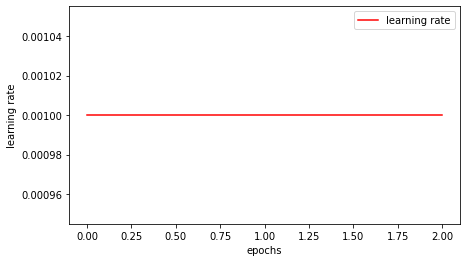

In [ ]:
import matplotlib.pyplot as plt

lr_label= 'learning rate'
plt.figure(figsize=(7, 4))
plt.plot(fit_lr, color='red', label=lr_label)
plt.xlabel('epochs')
plt.ylabel(lr_label)
plt.legend()
plt.savefig(f"./{lr_label}.png")
plt.show()

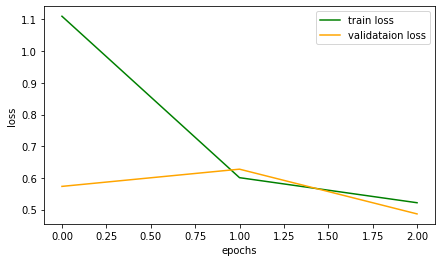

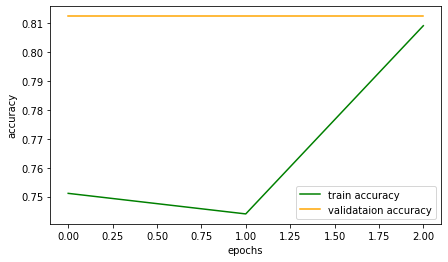

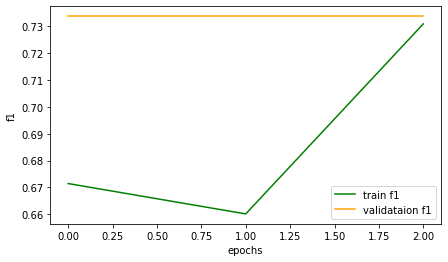

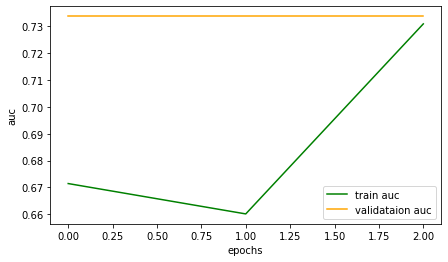

In [ ]:
import matplotlib.pyplot as plt

metrics = [(train_loss,val_loss), (train_acc,val_acc), (train_f1,val_f1), (train_auc,val_auc)]
names = ['loss', 'accuracy', 'f1', 'auc']
for i in range(len(names)):
  plt.figure(figsize=(7, 4))
  plt.plot(metrics[i][0], color='green', label=f'train {names[i]}')
  plt.plot(metrics[i][1], color='orange', label=f'validataion {names[i]}')
  plt.xlabel('epochs')
  plt.ylabel(names[i])
  plt.legend()
  plt.savefig(f"./{names[i]}.png")
  plt.show()

# Test

In [ ]:
test_dataset = MelanomaDataset(test['path'], test['target'])
test_loader = DataLoader(test_dataset, batch_size=params['batch_size']*10)

In [ ]:
images, labels = next(iter(test_loader))
images.shape, labels.shape

In [ ]:
from tqdm import tqdm
# model = torch.load('resnet18.pth',map_location=torch.device(params['device']))
# model.to(params['device'])
model.eval()
preds = torch.tensor([]).to(params['device'])
val_outputs = torch.tensor([])
val_targets = torch.tensor([])
stream = tqdm(test_loader)
metric_monitor = MetricMonitor()
with torch.no_grad():
  for i, batch in enumerate(stream, start=1):
    imgs, targets = batch
    imgs, targets = imgs.to(params['device']), targets.to(params['device'])
    outputs = model(imgs)
    #outputs = torch.sigmoid(outputs)
    preds = torch.cat([preds, outputs.view(-1)])
    val_outputs = torch.cat([val_outputs, outputs.cpu()])
    val_targets = torch.cat([val_targets, targets.cpu()])
    accuracy = accuracy_score(val_outputs, val_targets)
    auc = auc_score(val_outputs, val_targets)
    f1 = f1_score_(val_outputs, val_targets)
    recall = recall_score_(val_outputs, val_targets)
    # spec = specificity(val_outputs.cpu().detach().numpy(), val_targets.cpu().detach().numpy())
    metric_monitor.update("Accuracy", accuracy)
    metric_monitor.update("F1", f1)
    metric_monitor.update("AUC", auc)
    metric_monitor.update("Recall", recall)
    # metric_monitor.update("Specificity", spec)
    stream.set_description("Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))

Validation. Accuracy: 0.749 | F1: 0.641 | AUC: 0.657 | Recall: 0.000:  60%|██████    | 3/5 [11:24<07:36, 228.00s/it]


KeyboardInterrupt: ignored